In [1]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
from sklearn import preprocessing
import category_encoders as ce
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

data = pd.read_csv('hotels.csv')

# Преобразование object-признаков

## date

In [2]:
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=False)

display(data['review_date'].min())

display(data['review_date'].max())

Timestamp('2015-08-04 00:00:00')

Timestamp('2017-08-03 00:00:00')

Выделим квартал и месяц, в которые был написан отзыв.

In [3]:
data['quarter'] = data['review_date'].dt.quarter
data['quarter'].value_counts()

quarter
3    106850
2     99123
1     91148
4     89682
Name: count, dtype: int64

In [4]:
data['month'] = data['review_date'].dt.month
data['month'].value_counts()

month
8     37911
7     37141
5     34684
10    32972
6     32226
4     32213
9     31798
1     31512
3     30901
12    29713
2     28735
11    26997
Name: count, dtype: int64

## tags

In [5]:
'''
c = Counter()
def get_list_of_tag(line):
    global c
    lst = line.split(",")
    lst = list(map(lambda x: x.strip(' []\''),lst))
    c = c + Counter(lst)
    
data['tags'].apply(get_list_of_tag)
print(c)

poular_tegs = [i for i in c if c[i]>10000]
print(len(poular_tegs), poular_tegs)
'''

'\nc = Counter()\ndef get_list_of_tag(line):\n    global c\n    lst = line.split(",")\n    lst = list(map(lambda x: x.strip(\' []\'\'),lst))\n    c = c + Counter(lst)\n    \ndata[\'tags\'].apply(get_list_of_tag)\nprint(c)\n\npoular_tegs = [i for i in c if c[i]>10000]\nprint(len(poular_tegs), poular_tegs)\n'

Функция get_list_of_tag выполняется слишком долго, далее будет использоваться заранее подготовлненный список тегов, колличество которых превышает 10 тыс.

Надо в тегах заменить пробел на _, если я хочу их использовать как названия признаков, но при этом надо сохранить теги в исходном виде.

In [6]:
poular_tegs = ['Leisure trip', 'Couple', 'Stayed 2 nights', 'Submitted from a mobile device', \
    'Business trip', 'Standard Double Room', 'Stayed 1 night', 'Solo traveler', 'Stayed 3 nights',\
        'Standard Double or Twin Room', 'Superior Double Room', 'Stayed 4 nights', 'Double Room', \
            'Family with young children', 'Double or Twin Room', 'Group', 'Family with older children',\
                'Classic Double Room', 'Stayed 5 nights', 'Deluxe Double Room', 'Superior Double or Twin Room']

list_of_tags = poular_tegs.copy()

for n, i in enumerate(poular_tegs):
    poular_tegs[n] = i.replace(' ', '_')
    
print(poular_tegs)
print(list_of_tags)

['Leisure_trip', 'Couple', 'Stayed_2_nights', 'Submitted_from_a_mobile_device', 'Business_trip', 'Standard_Double_Room', 'Stayed_1_night', 'Solo_traveler', 'Stayed_3_nights', 'Standard_Double_or_Twin_Room', 'Superior_Double_Room', 'Stayed_4_nights', 'Double_Room', 'Family_with_young_children', 'Double_or_Twin_Room', 'Group', 'Family_with_older_children', 'Classic_Double_Room', 'Stayed_5_nights', 'Deluxe_Double_Room', 'Superior_Double_or_Twin_Room']
['Leisure trip', 'Couple', 'Stayed 2 nights', 'Submitted from a mobile device', 'Business trip', 'Standard Double Room', 'Stayed 1 night', 'Solo traveler', 'Stayed 3 nights', 'Standard Double or Twin Room', 'Superior Double Room', 'Stayed 4 nights', 'Double Room', 'Family with young children', 'Double or Twin Room', 'Group', 'Family with older children', 'Classic Double Room', 'Stayed 5 nights', 'Deluxe Double Room', 'Superior Double or Twin Room']


In [7]:
for n, i in enumerate(poular_tegs):
    data['tag_' + str(i)] = data['tags'].apply(lambda x: True if list_of_tags[n] in x else False)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [9]:
data['tag_Stayed_2_nights'].value_counts()

tag_Stayed_2_nights
False    286540
True     100263
Name: count, dtype: int64

## days_since_review

Преобразуем признак в int

In [10]:
def days_these_days(line):
    line = line.strip(' days')
    line = int(line)
    return line

In [11]:
data['days_since_review'] = data['days_since_review'].apply(days_these_days)
data['days_since_review'].value_counts()

days_since_review
1      1911
322    1738
120    1702
338    1462
534    1451
       ... 
122     154
243     154
615     146
124     127
123     111
Name: count, Length: 731, dtype: int64

## address and name

Адрес можно использовать, чтобы извлечь страну, в которой расположен отель. Страну отеля возможно можно использовать в дальнейшем.

In [12]:
data['hotel_address'].value_counts()

hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              3587
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     3206
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     3095
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    2688
7 Pepys Street City of London London EC3N 4AF United Kingdom                      2379
                                                                                  ... 
Via Palmanova 153 20132 Milan Italy                                                  7
40 Rue Rene Boulanger 10th arr 75010 Paris France                                    7
Via M Buonarroti 13 Fiera Milano City 20149 Milan Italy                              6
Johann Staud Stra e 32 16 Ottakring 1160 Vienna Austria                              6
13 Rue Fran ois Ory 92120 Paris France                                               5
Name: count, Length: 1493, dt

In [13]:
def get_country(line):
    splited = line.split(' ')
    return splited[-1]

In [14]:
data['hotel_country'] = data['hotel_address'].apply(get_country)
data['hotel_country'] = data['hotel_country'].replace('Kingdom' , 'United Kingdom')
data['hotel_country'].value_counts()

hotel_country
United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: count, dtype: int64

Не придумал как можно использовать имя, возможный кандидат на удаление

In [15]:
data['hotel_name'].value_counts()

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: count, Length: 1492, dtype: int64

Закодируем страну отеля

In [16]:
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True)
type_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, type_bin], axis=1)

## reviewer_nationality

In [17]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x : x.strip(' '))

Создадим булевый признак, равный True, если национальность ревьювера и отеля совпадают.

In [18]:
data['subjectivity'] = data['reviewer_nationality'] == data['hotel_country']
data['subjectivity'].value_counts()

subjectivity
False    252862
True     133941
Name: count, dtype: int64

In [19]:
data['reviewer_nationality'].value_counts(normalize=True)

reviewer_nationality
United Kingdom              0.475780
United States of America    0.068616
Australia                   0.041983
Ireland                     0.028764
United Arab Emirates        0.019692
                              ...   
Cook Islands                0.000003
Guinea                      0.000003
Comoros                     0.000003
Anguilla                    0.000003
Grenada                     0.000003
Name: proportion, Length: 225, dtype: float64

Преобразуем малочисленные категории в категорию Other

In [20]:
non_summarize = ['United Kingdom', 'United States of America', 'Australia', 'Ireland']

def summarize_nat(line):
    if line not in non_summarize:
        return 'Other'
    else: return line
    
data['reviewer_nationality'] = data['reviewer_nationality'].apply(summarize_nat)
data['reviewer_nationality'].value_counts(normalize=True)

reviewer_nationality
United Kingdom              0.475780
Other                       0.384857
United States of America    0.068616
Australia                   0.041983
Ireland                     0.028764
Name: proportion, dtype: float64

Закодируем признак reviewer_nationality

In [21]:
encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True)
type_bin = encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

## review

Много негативных отзывов, которые на самом деле не негативные. Приведём их в единый вид

In [22]:
data['negative_review'] = data['negative_review'].apply(lambda x :x.strip(' ').lower())

In [23]:
data['negative_review'] = data['negative_review'].apply(lambda x : x.replace(x, 'no negative') if 'nothing' in x else x)

In [24]:
data['negative_review'].replace(['n a', 'none', '', 'all good', 'no complaints' , 'everything was perfect', \
    'na', 'nil', 'everything was great' , 'can t think of anything'], 'no negative', inplace=True)

In [25]:
data['negative_review'].value_counts().nlargest(10)

negative_review
no negative        129658
small room            424
breakfast             396
location              393
everything            330
price                 260
small rooms           229
leaving               178
very small room       167
expensive             156
Name: count, dtype: int64

Создадим булевый признак, равный True если нет негативного отзыва

In [26]:
data['No_Negative'] = data['negative_review'] == 'no negative'
data['No_Negative'].value_counts()

No_Negative
False    257145
True     129658
Name: count, dtype: int64

Проделаем то же самое с positive_review

In [27]:
data['positive_review'] = data['positive_review'].apply(lambda x :x.strip(' ').lower())
data['positive_review'].replace('nothing', 'no positive', inplace=True)
data['positive_review'].value_counts().nlargest(10)

positive_review
no positive           28182
location               8843
everything             2453
great location         1291
the location           1187
good location          1123
breakfast               591
friendly staff          545
excellent location      476
staff                   418
Name: count, dtype: int64

In [28]:
data['No_Positive'] = data['positive_review'] == 'no positive'
data['No_Positive'].value_counts()

No_Positive
False    358621
True      28182
Name: count, dtype: int64

# Преобразование числовых признаков

In [29]:
data_mult = data[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', \
    'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',\
        'reviewer_score', 'days_since_review', 'lat', 'lng' ]]

data_mult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         384355 non-null  float64
 9   lng                                         384355 non-null  float64
d

Здесь и при построении графика мультиколлинеарности рассматриваются только исходные числовые признаки

## Мультиколлинеарность для базовых

<Axes: >

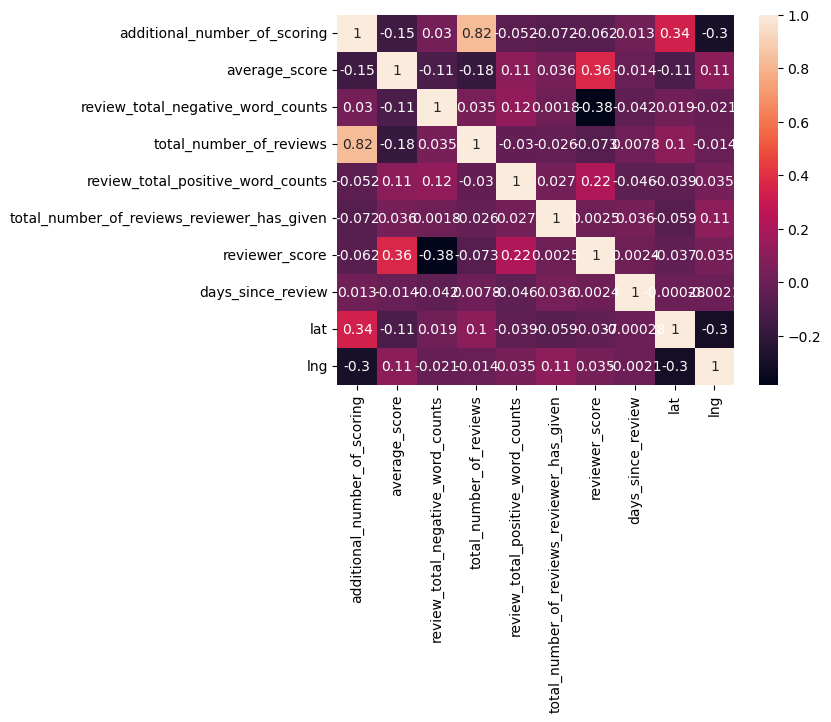

In [30]:
sns.heatmap(data_mult.corr(numeric_only=True), annot=True)

## Исследуем первые 7 признаков

### additional_number_of_scoring

кандидат на удаление из-за мультиколлинеарности с другим признаком (total_number_of_reviews)

In [31]:
data['additional_number_of_scoring'].describe()

count    386803.000000
mean        498.246536
std         500.258012
min           1.000000
25%         169.000000
50%         342.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

c:\Users\oxi-a\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\oxi-a\AppData\Local\Temp\ipykernel_10168\3089269231.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


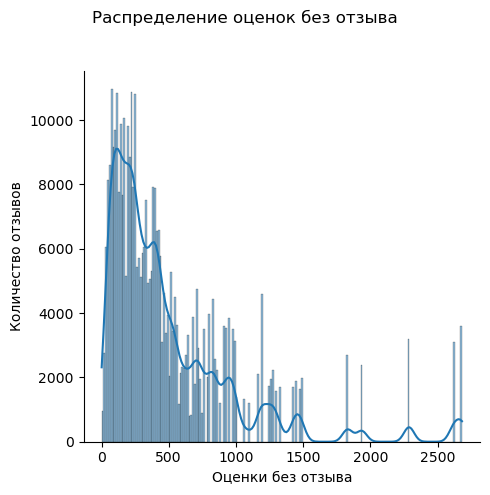

In [32]:
g = sns.displot(data, x="additional_number_of_scoring", kde=True)

g.set_axis_labels('Оценки без отзыва', 'Количество отзывов')
g.fig.suptitle('Распределение оценок без отзыва')

plt.tight_layout(rect=[0, 0, 1, 0.95])

Признак распределён ненормально, есть выбросы, нормализуем его методом _RobustScaler_.

In [33]:
r_scaler = preprocessing.RobustScaler()
data['additional_number_of_scoring'] = r_scaler.fit_transform(data[['additional_number_of_scoring']])

data['additional_number_of_scoring'].describe()

count    386803.000000
mean          0.318221
std           1.018855
min          -0.694501
25%          -0.352342
50%           0.000000
75%           0.647658
max           4.765784
Name: additional_number_of_scoring, dtype: float64

### average_score

In [34]:
data['average_score'].describe()

count    386803.000000
mean          8.397231
std           0.547881
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

c:\Users\oxi-a\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Количество оценок')

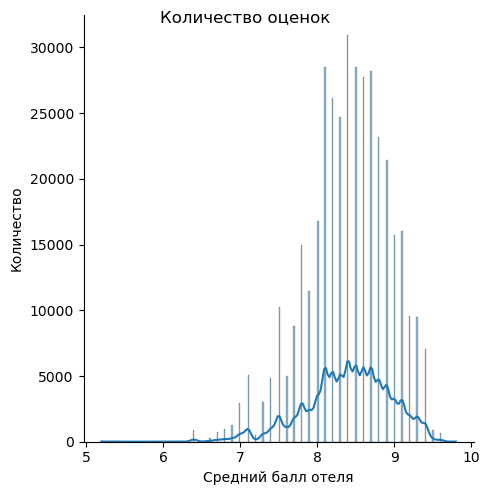

In [35]:
g = sns.displot(data, x="average_score", kde=True)

g.set_axis_labels('Средний балл отеля', 'Количество')
g.fig.suptitle('Количество оценок')

plt.tight_layout(rect=[0, 0, 1, 0.95])

В нормализации не нуждается

### review_total_negative_word_counts и review_total_positive_word_counts

In [36]:
display(data['review_total_negative_word_counts'].describe())
display(data['review_total_positive_word_counts'].describe())

count    386803.000000
mean         18.538988
std          29.703369
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

count    386803.000000
mean         17.776985
std          21.726141
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: review_total_positive_word_counts, dtype: float64

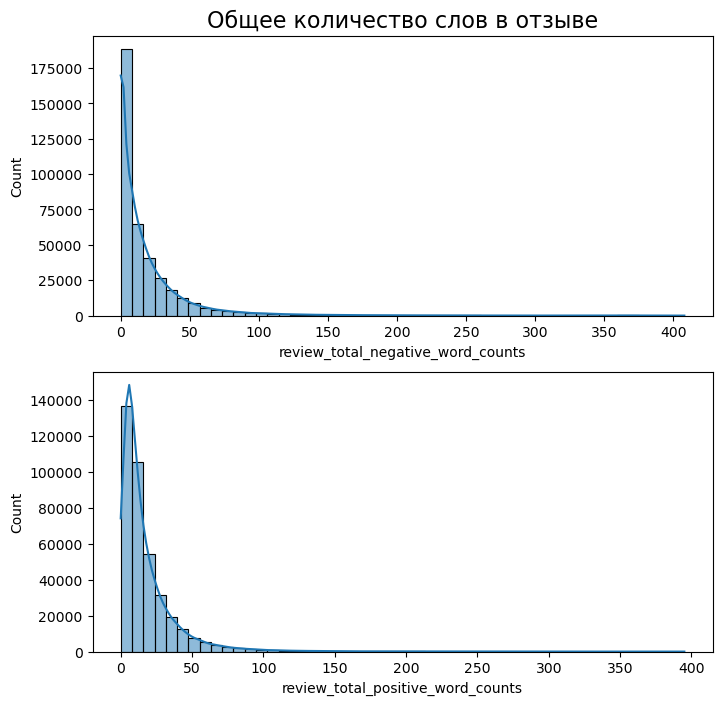

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
sns.histplot(
    data=data,
    x='review_total_negative_word_counts',
    bins=50,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Общее количество слов в отзыве', fontsize=16)
sns.histplot(
    data=data,
    x='review_total_positive_word_counts',
    bins=50,
    kde=True,
    ax=axes[1]
);

Оба графика распределены ненормально, имеются аномальные значения, нормализуем их так же методом _RobustScaler_.

In [38]:
data['review_total_negative_word_counts'] = r_scaler.fit_transform(data[['review_total_negative_word_counts']])
data['review_total_positive_word_counts'] = r_scaler.fit_transform(data[['review_total_positive_word_counts']])

display(data['review_total_negative_word_counts'].describe())
display(data['review_total_positive_word_counts'].describe())

count    386803.000000
mean          0.454238
std           1.414446
min          -0.428571
25%          -0.333333
50%           0.000000
75%           0.666667
max          19.000000
Name: review_total_negative_word_counts, dtype: float64

count    386803.000000
mean          0.398646
std           1.278008
min          -0.647059
25%          -0.352941
50%           0.000000
75%           0.647059
max          22.588235
Name: review_total_positive_word_counts, dtype: float64

### total_number_of_reviews

кандидат на удаление

In [39]:
data['total_number_of_reviews'].describe()

count    386803.000000
mean       2743.992042
std        2316.457018
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

c:\Users\oxi-a\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\oxi-a\AppData\Local\Temp\ipykernel_10168\1237433750.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


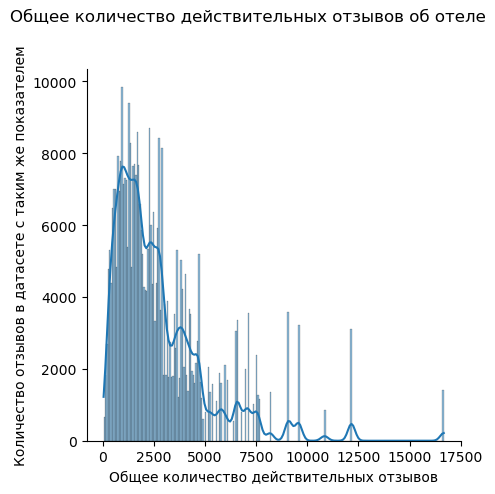

In [40]:
g = sns.displot(data, x="total_number_of_reviews", kde=True)

g.set_axis_labels('Общее количество действительных отзывов', 'Количество отзывов в датасете с таким же показателем')
g.fig.suptitle('Общее количество действительных отзывов об отеле')

plt.tight_layout(rect=[0, 0, 1, 0.95])

Распределение не нормально, имеются выбросы, для нормализации так же используем метод _RobustScaler_

In [41]:
data['total_number_of_reviews'] = r_scaler.fit_transform(data[['total_number_of_reviews']])

display(data['total_number_of_reviews'].describe())

count    386803.000000
mean          0.248773
std           0.944721
min          -0.852773
25%          -0.396819
50%           0.000000
75%           0.603181
max           5.928222
Name: total_number_of_reviews, dtype: float64

### total_number_of_reviews_reviewer_has_given

количество отзывов, которые рецензенты дали в прошлом

In [42]:
data['total_number_of_reviews_reviewer_has_given'].describe()

count    386803.00000
mean          7.17725
std          11.05442
min           1.00000
25%           1.00000
50%           3.00000
75%           8.00000
max         355.00000
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

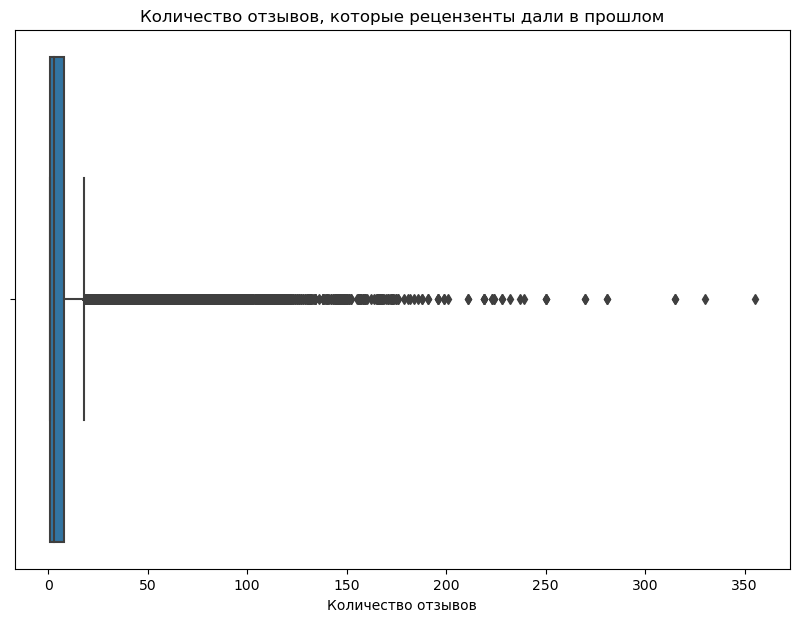

In [43]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=data,
    x='total_number_of_reviews_reviewer_has_given',
    orient='h',
    width=0.9
)
boxplot.set_title('Количество отзывов, которые рецензенты дали в прошлом');
boxplot.set_xlabel('Количество отзывов');

Ненормально, всё как раньше

In [44]:
data['total_number_of_reviews_reviewer_has_given'] = r_scaler.fit_transform(data[['total_number_of_reviews_reviewer_has_given']])

display(data['total_number_of_reviews_reviewer_has_given'].describe())

count    386803.000000
mean          0.596750
std           1.579203
min          -0.285714
25%          -0.285714
50%           0.000000
75%           0.714286
max          50.285714
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

### reviewer_score

целевой признак

c:\Users\oxi-a\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\oxi-a\AppData\Local\Temp\ipykernel_10168\3157779264.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


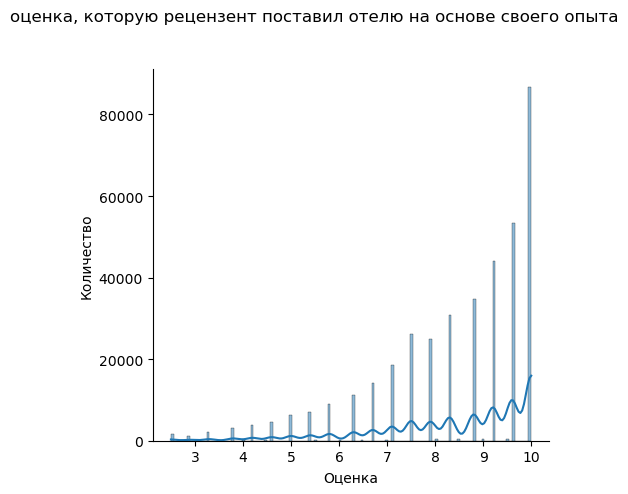

In [45]:
g = sns.displot(data, x="reviewer_score", kde=True)

g.set_axis_labels('Оценка', 'Количество')
g.fig.suptitle('оценка, которую рецензент поставил отелю на основе своего опыта')

plt.tight_layout(rect=[0, 0, 1, 0.95])

## Другое

### days_since_review

In [46]:
data['days_since_review'].describe()

count    386803.000000
mean        354.387978
std         208.975174
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

c:\Users\oxi-a\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\oxi-a\AppData\Local\Temp\ipykernel_10168\756568992.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


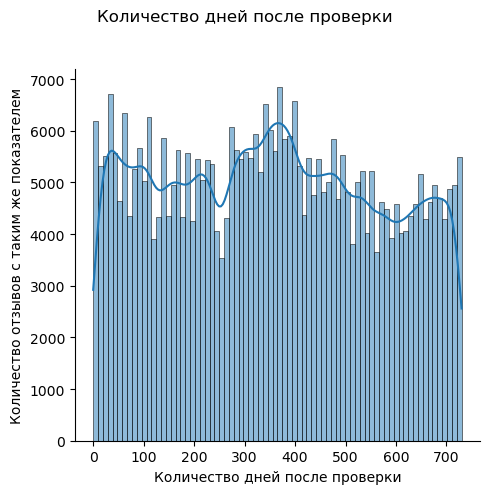

In [47]:
g = sns.displot(data, x="days_since_review", kde=True)

g.set_axis_labels('Количество дней после проверки', 'Количество отзывов с таким же показателем')
g.fig.suptitle('Количество дней после проверки')

plt.tight_layout(rect=[0, 0, 1, 0.95])

In [48]:
data['days_since_review'] = r_scaler.fit_transform(data[['days_since_review']])

display(data['days_since_review'].describe())

count    386803.000000
mean          0.003943
std           0.593679
min          -1.002841
25%          -0.505682
50%           0.000000
75%           0.494318
max           1.071023
Name: days_since_review, dtype: float64

### LNG and NAT

Для нескольких отелей отсутствуют координаты, заменим пропуски примерным местоположением столицы государства, в котором расположен отель.

In [49]:
lat_of_capitals = {
    'United Kingdom' : 51.30,
    'Spain'  :  40.24,
    'France' :  48.50,
    'Netherlands' : 52.23,
    'Austria'   :   48.13,
    'Italy' :   41.54
}

lng_of_capitals = {
    'United Kingdom' : -0.7,
    'Spain'  :  -3.41,
    'France' :  2.20,
    'Netherlands' : 4.54,
    'Austria'   :   16.22,
    'Italy' :   12.30
}

In [50]:
data['lat_fill'] = data['hotel_country'].map(lat_of_capitals)
data['lng_fill'] = data['hotel_country'].map(lng_of_capitals)


data = data.fillna({'lat': data['lat_fill'], 'lng': data['lng_fill']})

data.drop(columns=['lat_fill', 'lng_fill'], inplace=True)

# Отбор признаков

## Подготовка

In [51]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data = data.drop(object_columns, axis = 1)
data.drop('review_date', axis = 1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 47 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   386803 non-null  float64
 1   average_score                                  386803 non-null  float64
 2   review_total_negative_word_counts              386803 non-null  float64
 3   total_number_of_reviews                        386803 non-null  float64
 4   review_total_positive_word_counts              386803 non-null  float64
 5   total_number_of_reviews_reviewer_has_given     386803 non-null  float64
 6   reviewer_score                                 386803 non-null  float64
 7   days_since_review                              386803 non-null  float64
 8   lat                                            386803 non-null  float64
 9   lng                                  

In [52]:
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', \
        'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review',\
                'lat', 'lng']

cat_cols = ['average_score',
       'quarter', 'month',
       'tag_Leisure_trip', 'tag_Couple', 'tag_Stayed_2_nights',
       'tag_Submitted_from_a_mobile_device', 'tag_Business_trip',
       'tag_Standard_Double_Room', 'tag_Stayed_1_night', 'tag_Solo_traveler',
       'tag_Stayed_3_nights', 'tag_Standard_Double_or_Twin_Room',
       'tag_Superior_Double_Room', 'tag_Stayed_4_nights', 'tag_Double_Room',
       'tag_Family_with_young_children', 'tag_Double_or_Twin_Room',
       'tag_Group', 'tag_Family_with_older_children',
       'tag_Classic_Double_Room', 'tag_Stayed_5_nights',
       'tag_Deluxe_Double_Room', 'tag_Superior_Double_or_Twin_Room',
       'hotel_country_United Kingdom', 'hotel_country_France',
       'hotel_country_Netherlands', 'hotel_country_Italy',
       'hotel_country_Austria', 'hotel_country_Spain', 'subjectivity',
       'reviewer_nationality_United Kingdom', 'reviewer_nationality_Other',
       'reviewer_nationality_United States of America',
       'reviewer_nationality_Ireland', 'reviewer_nationality_Australia',
       'No_Negative', 'No_Positive']

## Отбор

In [53]:
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score'] 

y=y.astype('int')

<Axes: >

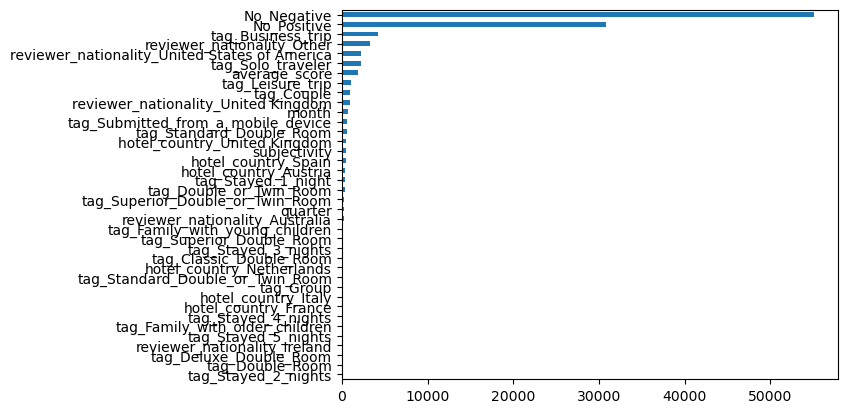

In [54]:
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Сохраним наименее полезные признаки в отдельный список

In [55]:
low_value_cats = imp_cat.loc[imp_cat < 500].index.tolist()
print(low_value_cats)
print(len(low_value_cats))

['tag_Stayed_2_nights', 'tag_Double_Room', 'tag_Deluxe_Double_Room', 'reviewer_nationality_Ireland', 'tag_Stayed_5_nights', 'tag_Family_with_older_children', 'tag_Stayed_4_nights', 'hotel_country_France', 'hotel_country_Italy', 'tag_Group', 'tag_Standard_Double_or_Twin_Room', 'hotel_country_Netherlands', 'tag_Classic_Double_Room', 'tag_Stayed_3_nights', 'tag_Superior_Double_Room', 'tag_Family_with_young_children', 'reviewer_nationality_Australia', 'quarter', 'tag_Superior_Double_or_Twin_Room', 'tag_Double_or_Twin_Room', 'tag_Stayed_1_night', 'hotel_country_Austria', 'hotel_country_Spain', 'subjectivity']
24


<Axes: >

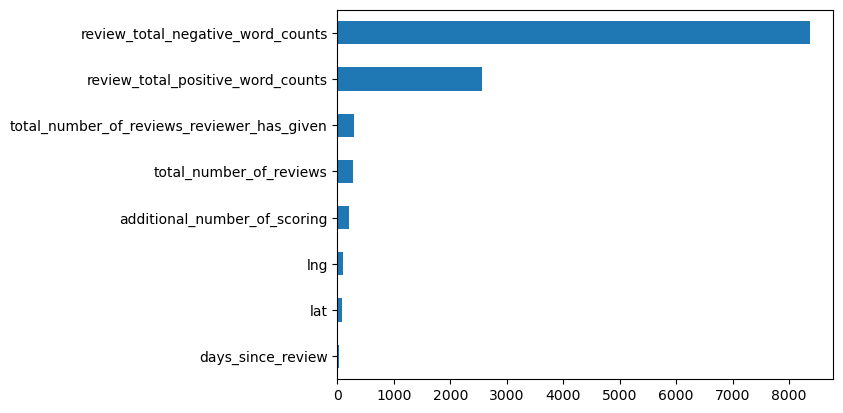

In [56]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<Axes: >

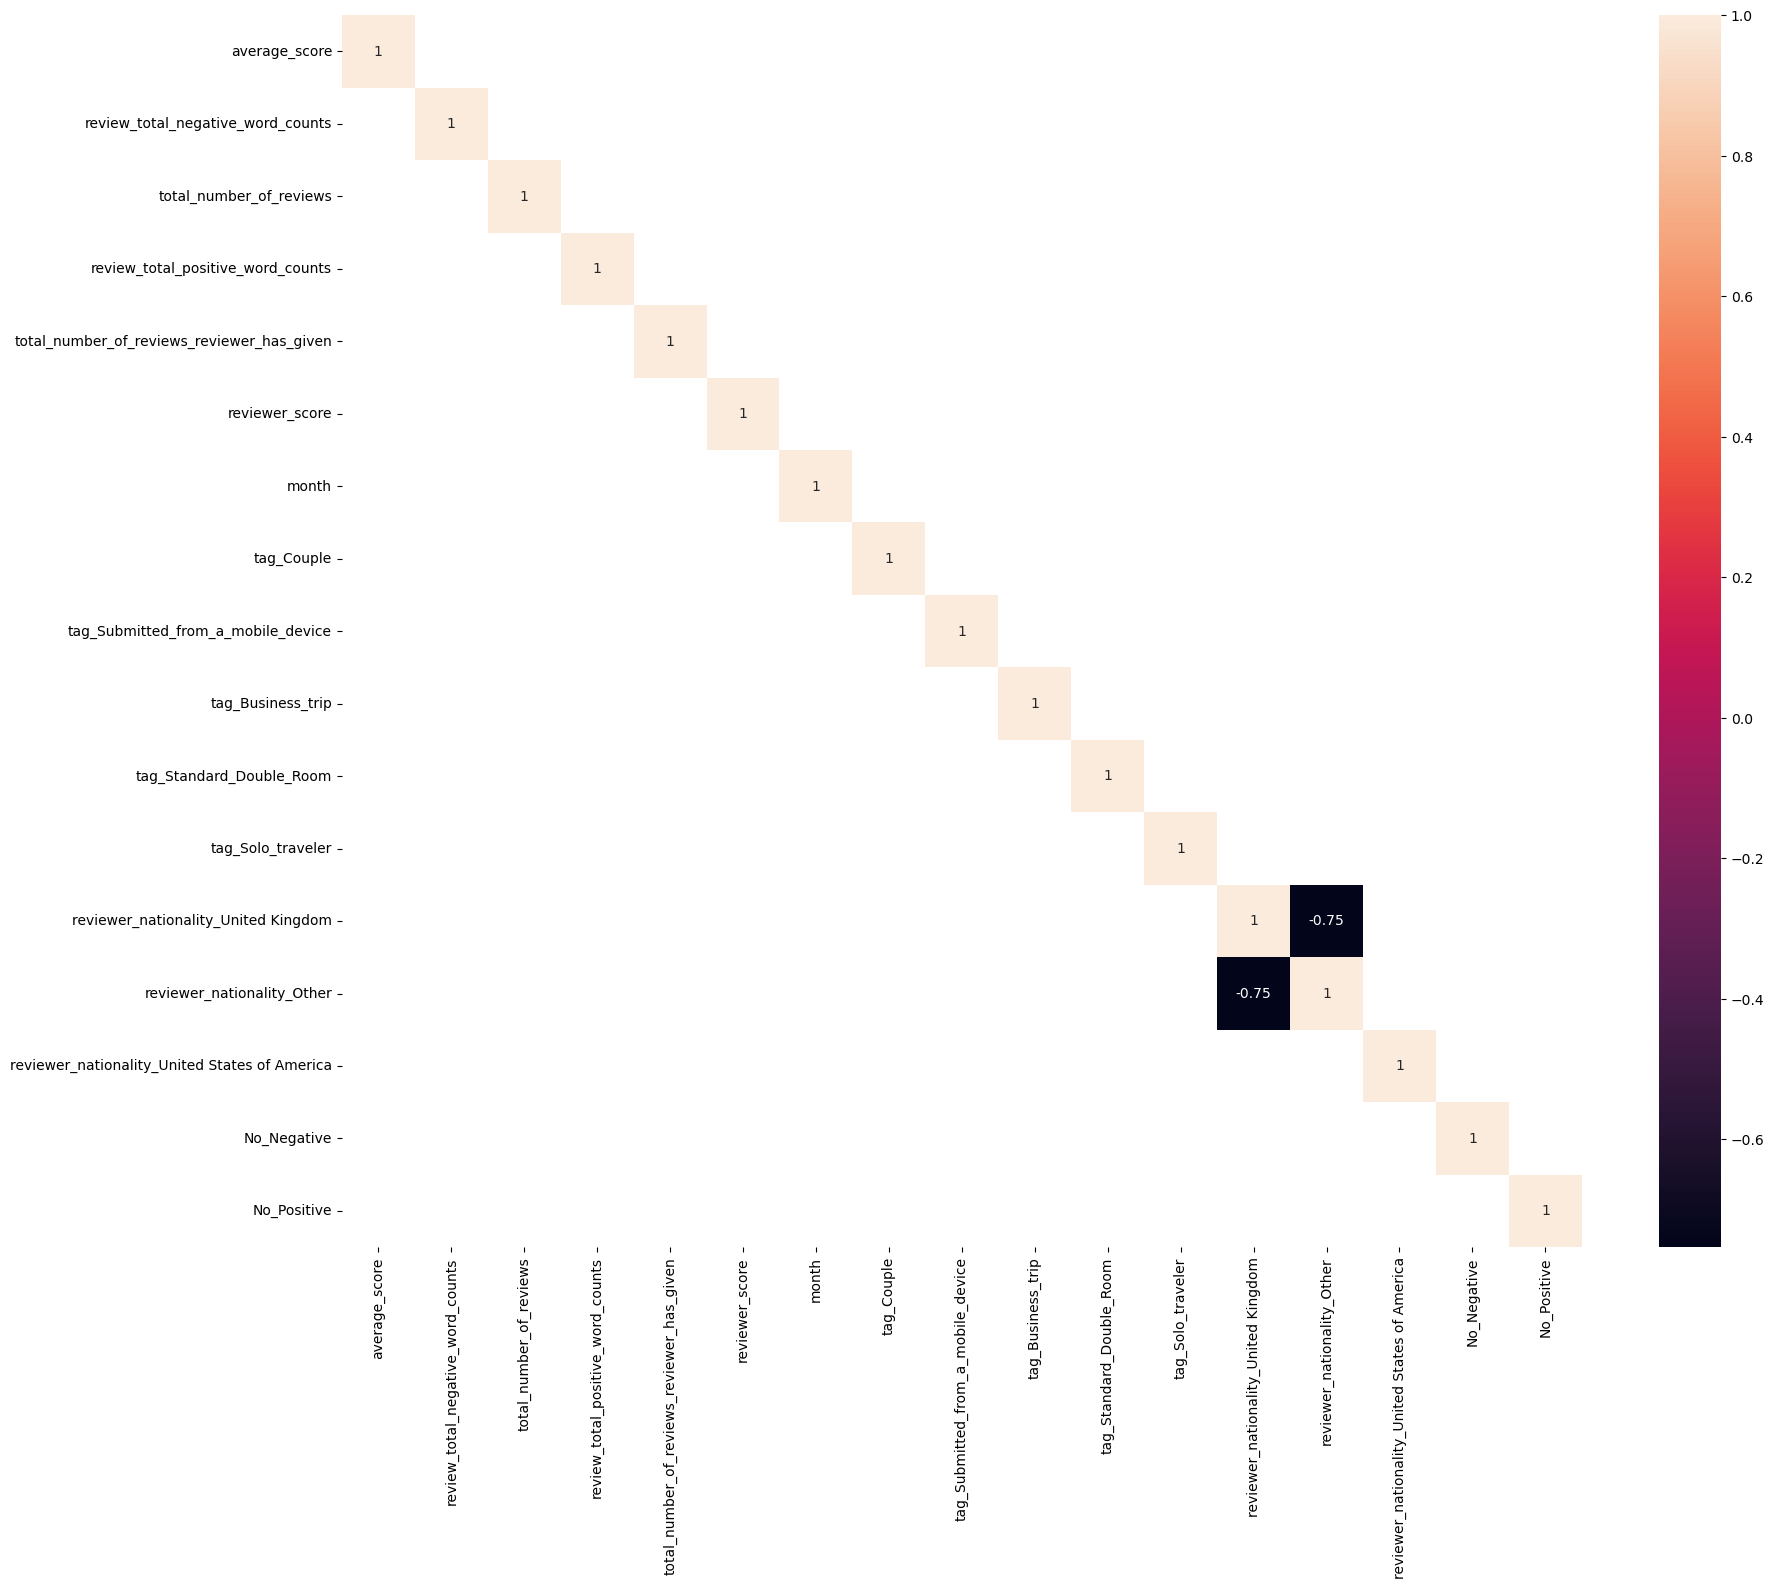

In [60]:
plt.figure(figsize=(20, 16))
sns.heatmap(data.corr(numeric_only=True), annot=True, mask=abs(data.corr(numeric_only=True)) < 0.7)


Мультиколлинеарные признаки:
- quarter <--> month
- additional_number_of_scoring <--> total_number_of_reviews
- lng <--> hotel_country_Austria
- lat <--> hotel_country_Spain
- reviewer_nationality_United Kingdom <--> reviewer_nationality_Other
- tag_Business_trip <--> tag_Leisure_trip

Выберем наименее полезные признаки, с высокой мультиколлинеарностью и из графиков

In [58]:
data.drop(['lng', 'lat', 'tag_Leisure_trip', 'hotel_country_United Kingdom', 'quarter',\
    'additional_number_of_scoring', 'days_since_review'] + low_value_cats, axis = 1, inplace=True)

In [59]:
data.to_csv('hotels_new.csv', index=False)